In [123]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import os,json,base64,io
import pydicom
import pandas as pd
from io import BytesIO,StringIO
import base64
from PIL import Image
import numpy as np
from ipydatagrid import DataGrid
from IPython.display import display
from ipywidgets import widgets, Output
%load_ext autoreload
%autoreload 2

class DICOMLabeler:
    def __init__(self,input_dir,ontology_file,label_file):
        
        self.classification_dict={}
        self.ontology_types=[]
        self.dicom_files=[]
        # Function to handle "Next" button click
        self.num_clicked=0        
        self.dataframe=None

        self._debug=0
        
        try:
            lay_fw=widgets.Layout(width='100%')
            #UI elements

            self.dcm_dir_text_input = widgets.Text(description='DICOM Dir:',value=input_dir,layout=lay_fw)
            self.dcm_dir=self.dcm_dir_text_input.value+'/'
            self.ontology_file_input=widgets.Text(description='Ontology file:',value=ontology_file,layout=lay_fw)
            self.label_file_input=widgets.Text(description='Label file:',value=label_file,layout=lay_fw)
            spl=os.path.splitext(label_file)
            self.label_file_save=widgets.Text(description='Output label file:',value=spl[0]+'_manual'+spl[1],layout=lay_fw)
            self.path_box=widgets.VBox([self.dcm_dir_text_input,self.ontology_file_input,self.label_file_input,self.label_file_save])                                                  
                        
            self.upload_ontology_button = widgets.FileUpload(description='Upload ontology', accept='.json', multiple=False)
            self.upload_ontology_button.observe(self.upload_json, names='data')
            self.upload_label_button=widgets.FileUpload(description='Upload label', accept='.csv', multiple=False)
            self.upload_label_button_output=Output()
            self.upload_label_button.observe(self.upload_classification_file, names='value')
            self.collect_button = widgets.Button(description='Review!')
            self.collect_button.on_click(self.collect_on_click)
            self.collect_button_output=Output()
            self.initialize_buttons_box=widgets.HBox([self.upload_ontology_button,self.upload_label_button,self.collect_button])
                        
            self.initialize_box=widgets.VBox([self.path_box,self.initialize_buttons_box,self.collect_button_output])

            #display(self.InitializeBox)
            #display(self.collect_button_output)

            self.columns_dropdown=widgets.Dropdown(description="Sort by:",options=[])
            self.sort_grid_columns_button=widgets.Button(description='Apply sort')
            self.sort_grid_columns_button.on_click(self.sort_grid_columns)

            self.scantypes_dropdown = widgets.Dropdown(description='Set scan type:', options=[])
            self.scantype_apply_button=widgets.Button(description='Apply')
            self.scantype_apply_button.on_click(self.apply_scan_type)

            self.save_button=widgets.Button(description='Save')
            self.save_button.on_click(self.save_dataframe)
            
            self.grid_control_box=widgets.HBox([self.columns_dropdown,self.sort_grid_columns_button,\
                                                self.scantypes_dropdown,self.scantype_apply_button,
                                               self.save_button])
            self.grid_box=widgets.VBox([])
            #display(self.grid_box)
    
            self.image_panel = widgets.Output(layout=widgets.Layout(width='50%', height='400px'))
    
            self.metadata_text1 = widgets.Textarea(description='DICOM:', layout=widgets.Layout(width='100%', height='300px'))
            self.metadata_text2 = widgets.Textarea(description='Classification:', layout=widgets.Layout(width='100%', height='100px'))

            self.grid_output=widgets.Output()
            #display(self.grid_output)
                
            panel0=widgets.VBox([self.metadata_text1],layout=widgets.Layout(width='50%', height='450px'))
            self.review_panel = widgets.HBox([panel0, self.image_panel])
            
            self.label_box=widgets.VBox([self.grid_box,self.review_panel,self.grid_output])
            #display(self.grid_output)
            #display(self.review_panel)


            self.chart_button=widgets.Button(description='Regenerate charts')
            self.chart_button.on_click(self.generate_charts)

            
            self.chart_panel1=widgets.Output(layout=widgets.Layout(width='100%'))
            self.chart_panel2=widgets.Output(layout=widgets.Layout(width='100%'))
            self.statistics_box=widgets.VBox([self.chart_button,self.chart_panel1,self.chart_panel2])
            
            self.main_tab=widgets.Tab()
            
            self.main_tab.children = [self.initialize_box,self.label_box,self.statistics_box]
            self.main_tab.titles=['Initialize','Review label','Statistics']
            
            display(self.main_tab)
            
            return
            
            self.finish_button = widgets.Button(description='Finish')
            self.finish_button_output = widgets.Output()
            print (4)
            self.finish_button.on_click(self.finish)
            self.download_link = widgets.HTML()
    
            self.test()
            self.file_generator=self.collect_files(0)    
            next_file=self.file_generator.next()

            #self.next_button = widgets.Button(description='Next')
            #self.next_button_output=Output()
            #self.next_button.on_click(next_file)
            
        except Exception as e:
            print("DICOM labeler initialization exception:",e)

    def generate_charts(self,b):
        self.generate_chart1()
        self.generate_chart2()
        
    def generate_chart1(self):
        with self.chart_panel1:
            #clear_output()
            try:
                print('panel1')
                # Count the occurrences of each ontology type in the labels1 column
                type_counts = self.dataframe['label_manual'].value_counts(normalize=True) * 100
                
                # Ensure all types from ontology_types are included in the plot, even if not present in the column
                type_counts = type_counts.reindex(self.ontology_types, fill_value=0)
                
                # Get the index and values for plotting
                x_labels = type_counts.index
                y_values = type_counts.values
                
                # Plot the data using matplotlib directly
                fig, ax = plt.subplots(figsize=(8, 5))
                ax.bar(x_labels, y_values, color='skyblue')
                
                # Customize the plot
                ax.set_ylabel('Percentage (%)')
                ax.set_xlabel('Ontology Type')
                ax.set_title('Percentage of Each Ontology Type in the manual_label Column')
                plt.xticks(rotation=45, ha='right')  # Rotate x-tick labels at a 45-degree angle and align to the right
                ax.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()  # Adjust the plot to ensure everything fits within the figure
                
                # Show the plot
                plt.show()
            except Exception as e:
                print('Exception in generate_chart1: ', e)

    def generate_chart2(self):
        with self.chart_panel2:
            try:
                print('panel2')
                #clear_output()
                fig, ax = plt.subplots(figsize=(10, 6))
                
                for column in ['probs1', 'probs2', 'pred_gini_impurity', 'pred_margin_confidence']:
                    data = self.dataframe[column]
                    # Use density=True for the relative cumulative frequency, and bins=100 for smoother curves
                    ax.hist(data, bins=100, density=True, cumulative=True, label=column, histtype='step', linewidth=1.5)
                
                # Customize the plot
                ax.set_title('Cumulative Distribution of Prediction Metrics')
                ax.set_xlabel('Value')
                ax.set_ylabel('Cumulative Probability')
                ax.grid(True, which='both', linestyle='--', linewidth=0.5)
                ax.legend(loc='upper left')
                
                # Show the plot
                plt.show()
            except Exception as e:
                print('Exception in generate_chart2: ',e)
            
    def test (self):
        print("this is a test")

    def on_grid_cell_click(self,event):
        '''
        determine file from selection and display file
        '''
        with self.grid_output:
            #self.collect_button_output.clear_output()
            if self._debug>0: print("on_grid_cell_click") 
            row=event['row']
            column = self.dataframe.columns.get_loc('files')
            file=self.dataframe.iloc[row,column]
            if self._debug>0: print('displaying file', file)
            self.display_file(file)

    def sort_grid_columns(self,b):        
        selected_column=self.columns_dropdown.value
        if selected_column is not None and len(selected_column)>0:
            if self._debug>0: print('sorting by',selected_column)
            self.dataframe.sort_values(selected_column,inplace=True)            
            self.dataframe.index = range(0,len(self.dataframe))
            self.display_grid_interface()

    def save_dataframe(self,b)
        self.grid_output.clear_output()
        with self.grid_output:
            try:
                save_file=self.label_file_save.value
                self.dataframe.to_csv(save_file)
                print('spreadsheet saved to',save_file)
            except Exception as e:
                print('Exception saving dataframe:',e)
                
    def apply_scan_type(self,b):
        '''
        set scan type to selection and update the display grid.
        '''
        with self.grid_output:           
            try:
                type=self.scantypes_dropdown.value
                if self._debug>0: print('setting type to',type)
                if type is None or type=="": return
                sel=self.datagrid.selections
                for s in sel:
                    row1,row2=s['r1'],s['r2']
                    #self.dataframe.at[row,'label_manual']=type
                    self.dataframe.loc[row1:row2,'label_manual']=type
                    
                self.display_grid_interface()
            except Exception as e:
                print('Exception in apply_scan_type:',e)
        return
        
        sel=self.datagrid.selected_cell_values
        ncols=len(self.dataframe.columns)
        sd_index=self.dataframe.columns.get_loc("series_descriptions")
        if self._debug>0: print('selected cells:',sel)                
        return
        nSelectedRows=len(sel)/ncols
        ind=sd_index
        if self._debug>0: print('Selected series descriptions:')
        while ind<nSelectedRows*ncols:
            print(sel[ind])
            ind+=ncols


    def display_grid_interface(self,df=None):
        #print("aaa")
        #global panel, next_button, self.scantypes_dropdown, finish_button, download_link
            
        with self.grid_output:
            try:
                if self._debug>0: print('creating grid interface')

                if df is None:
                    df=self.dataframe
                else:
                    self.dataframe=df
                    
                #if manual label does not exist, copy it from the 'labels1' column.
                if 'label_manual' not in df:
                    df.insert(1,'label_manual',df['labels1'])
                self.datagrid=DataGrid(df,editable=False,selection_mode="row")
                self.datagrid.layout.height="300px"
                self.datagrid.auto_fit_columns=True
                self.datagrid.on_cell_click(self.on_grid_cell_click)            
                self.datagrid.observe(self.on_grid_observe)
                self.grid_box.children=[self.grid_control_box,self.datagrid]
                self.columns_dropdown.options=df.columns
            except Exception as e:
                print('Exception in display_grid_interface:',e)

    def collect_on_click(self,b):
        '''
        Load nomenclature, make list of files and initialize all interfaces after collect button is pressed
        '''        
        with self.collect_button_output:
            print("collect_on_click")
            self.upload_json(0)
            if not self.dataframe: #attempt to load label file from local resource
                lf=self.label_file_input.value
                if not os.path.isfile(lf):
                    print('collect_on_click: no label file')
                    return
                self.init_dataframe(lf)
                
            self.main_tab.selected_index=1
            self.display_grid_interface(self.dataframe)
            #display(self.ReviewPanel)
            

    def upload_json(self, change):
        '''
        Handle the upload of the JSON file that describes the onltology.
        '''
        try:
            #check for the local ontology file.
            # Check if there is an uploaded file
            if os.path.isfile(self.ontology_file_input.value):
                with open(self.ontology_file_input.value) as f:
                    parsed_json=json.load(f)
            
            elif self.upload_ontology_button.value:
                # Get the file info for the first uploaded file
                file_info = self.upload_ontology_button.value[-1]
                file_content = file_info['content']
        
                # Convert memoryview to bytes, then decode to string
                json_str = bytes(file_content).decode('utf-8')
        
                # Parse JSON string manually
                parsed_json = json.loads(json_str)
            else:
                return
        
            # Assuming the JSON is a list of types
            self.ontology_types = parsed_json['scan_types'] if isinstance(parsed_json['scan_types'], list) else []        
            self.scantypes_dropdown.options = self.ontology_types
        except Exception as e:
            display(f"Error: {e}")    


    def collect_files(self,b):
        '''
        Make a list of DICOM files recursively from root dir.
        '''
        #with self.collect_button_output.capture(clear_output=True):
        print('collecting files')
        root_dir = self.dcm_dir
        
        for root, dirs, files in os.walk(root_dir):
            # Filter and sort DICOM files in each directory
            dicom_files_in_dir = [f for f in files if is_dicom_file(os.path.join(root, f))]
            if dicom_files_in_dir:
                dicom_files_in_dir.sort()
                middle_file = dicom_files_in_dir[len(dicom_files_in_dir) // 2]  # Pick the middle file
                yield os.path.join(root, middle_file)

    def is_dicom_file(self,file_path):
        '''
        Return flag whether file can be read as DICOM.
        '''
        try:
            # Attempt to read only the file's metadata
            pydicom.dcmread(file_path, stop_before_pixels=True)
            return True
        except:
            return False

    def get_file_classification_data(self,file_path):
        if self.classification_dict['files'].index(file_path)<0: return {}
        out_dict={}
        for key in self.classification_dict.keys():
            out_dict[key]=self.classification_dict[key][ind]
    
        #set the dropdown value.
        '''
        if 'labels1' in out_dict:
            label1=self.classification_dict['labels1'][ind]
            if label1 in self.scantypes_dropdown.options:
                self.scantypes_dropdown.value=label1
        '''
        return out_dict

    def format_file_classification_string(self,d):
        str=''
        if not d: return str;
        str+="L1: {}, p={:0.2f}\n".format(d['labels1'],d['probs1'])
        str+="L2: {}, p={:0.2f}\n".format(d['labels2'],d['probs2'])
        str+="GI: {:0.2f}, MC: {:0.2f}".format(d['pred_gini_impurity'],d['pred_margin_confidence'])
        return str
    
    # Function to display the DICOM file
    def display_file(self,file_path):
        '''
        Display the image in DICOM file.
        '''
        try:
            self.image_panel.clear_output(wait=False)
            self.metadata_text1.value=""
            self.metadata_text2.value=""
            
            with open(file_path, 'rb') as f:
                ds = pydicom.dcmread(f)
                prioritized_tags = ['SeriesDescription', 'ImageType', 'PixelSpacing','SliceThickness']
                metadata_str = ''
                for tag in prioritized_tags:
                    if tag in ds:
                        metadata_str += f"{tag}: {ds[tag].value}\n"
        
                # Add the rest of the tags, excluding PixelData
                metadata_str += "\n"+"\n".join([f"{tag}: {ds[tag].value}" 
                                           for tag in ds.dir() 
                                           if hasattr(ds[tag], 'value') and tag not in ['PixelData'] + prioritized_tags])
        
                self.metadata_text1.value = metadata_str
    
                #now populate classification panel, if classification is provided.                      
                truncated_path=file_path[file_path.startswith(self.dcm_dir) and len(self.dcm_dir):]
                #self.metadata_text2.value = self.format_file_classification_string(self.get_file_classification_data(truncated_path))
    
                ds.decompress()
                # Process the DICOM image
                image = ds.pixel_array
        
                # Handle multi-dimensional images (e.g., 3D or color images)
                sh=image.shape
                if image.ndim == 4:
                    # Taking the first slice for simplicity
                    image=image[sh[2]//2][sh[3]//2]
        
                elif image.ndim==3:
                    image=image[sh[2]//2]
        
                # Normalize and convert to uint8
                image = image - np.min(image)
                if np.max(image) != 0:
                    image = image / np.max(image) * 255
                image = image.astype(np.uint8)
        
                # Convert to PIL image
                pil_img = Image.fromarray(image)
        
                # Convert the PIL image to a byte buffer
                buffer = io.BytesIO()
                pil_img.save(buffer, format="JPEG")
                buffer.seek(0)
        
                # Display the image in the output widget
                with self.image_panel:
                    #clear_output(wait=True)
                    display(pil_img)
                    #
                    #image_widget = widgets.Image(value=buffer.read(), format='jpeg')
                    #image_widget.layout.max_width = '400px'  # Set the maximum width
                    #image_widget.layout.max_height = '400px'  # Set the maximum height
                    #display(image_widget)
        except Exception as e:
            display(f"Image display error: {e}")


    def upload_classification_file(self,change):
        '''
        upload file with label generated by a classifier.
        '''        
        self.classification_dict.clear()
        uc=self.upload_label_button    
        try:
            if uc.value:            
                file_content=uc.value[0]['content']
                object=BytesIO(file_content)
                df=pd.read_csv(object)
    
                # Loop through each column in the DataFrame and add it to the dictionary
                for column in df.columns:
                    # Check the data type of the column and convert to list
                    if df[column].dtype == 'object':  # For strings
                        self.classification_dict[column] = df[column].astype(str).tolist()
                    else:  # For real numbers
                        self.classification_dict[column] = df[column].astype(float).tolist() 
                self.dataframe=df                
                
        except Exception as e: 
            print(e)

    def init_dataframe(self,file):        
        with self.grid_output:
            try:                    
                if os.path.isfile(file):
                    self.dataframe=pd.read_csv(file)
            except Exception as e:
                print('Exception in init_dataframe:',e)
        
    # Function to handle "Finish" button click
    def finish(b):
        with self.finish_button_output.capture(clear_output=True):
            try:
                print('creating data frame')
                #padded_file_types = file_types + [None] * (len(dicom_files) - len(file_types))
            
                df = pd.DataFrame({'files': dicom_files,
                                   'user_label': file_types})
                
                output_file = StringIO()
                df.to_csv(output_file, index=False)
                output_file.seek(0)
                print ('creating link')
                b64 = base64.b64encode(output_file.getvalue().encode()).decode()
                href = f'<a href="data:application/octet-stream;base64,{b64}" download="output.csv">Download CSV</a>'
                self.download_link.value = href
                print('created link')
                
            except Exception as e: 
                print("Error: ", e)
        

    def on_grid_observe(self,e):
        with self.grid_output:
            #print('on_grid_observe')
            #print ('name:', e.name)
            if e.name=='selections':
                sel=self.datagrid.selected_cell_values
                ncols=len(self.dataframe.columns)
                sd_index=self.dataframe.columns.get_loc("series_descriptions")
                #print('selected cells:',sel)                
                #if self._debug>0: 
                #    print('selections:',self.datagrid.selections)
                #    print('selected_cell_values:',self.datagrid.selected_cell_values)
                    
                return
                nSelectedRows=len(sel)/ncols
                ind=sd_index
                print('Selected series descriptions:')
                while ind<nSelectedRows*ncols:
                    print(sel[ind])
                    ind+=ncols
            
    


SyntaxError: invalid syntax (1776544436.py, line 206)

In [124]:
dl=DICOMLabeler('/data/MIRRIR/archive/M19004_AS','/home/mmilchenko/src/scan_classifier/test/neuro_onc.json',\
               '/data/MIRRIR/archive/M19004_AS/classification_output_model_fc_39374-600.03.20.2024_2024Mar22_120535.csv')

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a DataFrame for demonstration (replace with your actual DataFrame)
self.dataframe = pd.DataFrame({
    'probs1': np.random.rand(100),
    'probs2': np.random.rand(100),
    'pred_gini_impurity': np.random.rand(100),
    'pred_margin_confidence': np.random.rand(100)
})

# Plotting the cumulative distribution for each column
fig, ax = plt.subplots(figsize=(10, 6))

for column in ['probs1', 'probs2', 'pred_gini_impurity', 'pred_margin_confidence']:
    data = self.dataframe[column]
    # Use density=True for the relative cumulative frequency, and bins=100 for smoother curves
    ax.hist(data, bins=100, density=True, cumulative=True, label=column, histtype='step', linewidth=1.5)

# Customize the plot
ax.set_title('Cumulative Distribution of Prediction Metrics')
ax.set_xlabel('Value')
ax.set_ylabel('Cumulative Probability')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(loc='upper left')

# Show the plot
plt.show()


NameError: name 'self' is not defined

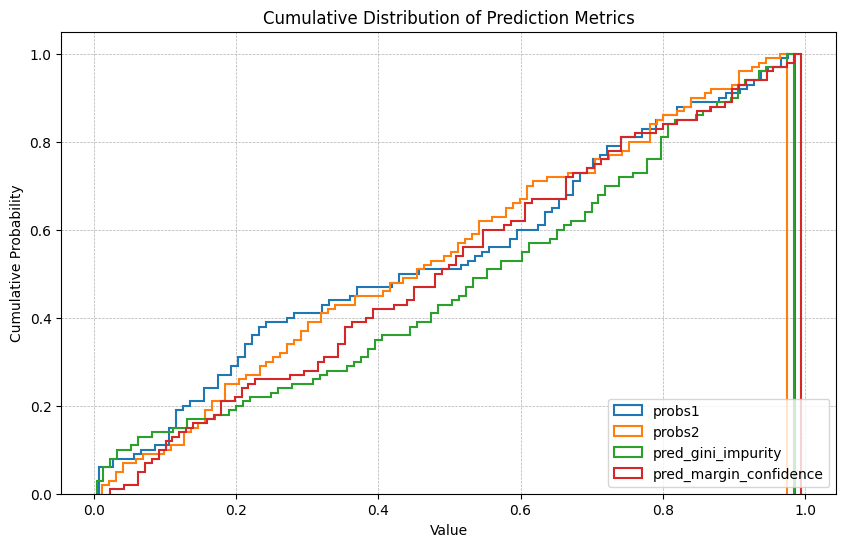

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a DataFrame for demonstration (replace with your actual DataFrame)
dataframe = pd.DataFrame({
    'probs1': np.random.rand(100),
    'probs2': np.random.rand(100),
    'pred_gini_impurity': np.random.rand(100),
    'pred_margin_confidence': np.random.rand(100)
})

# Plotting the cumulative distribution for each column
fig, ax = plt.subplots(figsize=(10, 6))

for column in ['probs1', 'probs2', 'pred_gini_impurity', 'pred_margin_confidence']:
    data = sorted(dataframe[column])  # Sort the data
    # Append the maximum data value + a small increment to ensure the last bin goes to 1
#    data += [data[-1] + 0.01]
    # Plot the cumulative histogram manually by defining weights for a true cumulative distribution
    weights = np.ones(len(data)) / len(data)
    ax.hist(data, bins=100, weights=weights, cumulative=True, label=column, histtype='step', linewidth=1.5)

# Customize the plot
ax.set_title('Cumulative Distribution of Prediction Metrics')
ax.set_xlabel('Value')
ax.set_ylabel('Cumulative Probability')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(loc='lower right')

# Show the plot
plt.show()


In [74]:
data[-1]

1.00366299080394

In [79]:
s=os.path.splitext('/home/user/somefile.txt')
s[1]

'.txt'